## Продолжаем реализовывать алгоритм Виолы-Джонса

в прошлой части мы уже сгенерировали значения признаков Хаара на позитивных и негативных примерах,
загрузим их

In [149]:
from collections import defaultdict
import _pickle as pickle

import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

from pprint import pprint
import pandas as pd

In [150]:
with open('positive_data.pkl', 'rb') as f:
    positive_features_full = pickle.load(f)

with open('negative_data.pkl', 'rb') as f:
    negative_features_full = pickle.load(f)

# Основная часть (10 баллов)

## Подготовим тренировочный набор

Ограничим количество примеров пока модель не начнет учиться

In [151]:
# objects_count = len(negative_features_full)
objects_count = 3000
# objects_count = None  снимите ограничение для достижения лучших результатов


positive_features = positive_features_full[:objects_count]
negative_features = negative_features_full[:objects_count]

In [152]:
y_positive = np.ones(len(positive_features))
y_negative = np.zeros(len(negative_features))

X = np.concatenate((positive_features, negative_features))
y = np.concatenate((y_positive, y_negative))

Разделим выборку на обучающую и тестовую

In [153]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Базовый классификатор (2 балла)

В качестве базового классификатора мы будем использовать "решающий пень" (decision stump)
Decision stump -- это минимально возможное решающее дерево, имеющее два параметра threshold и polarity

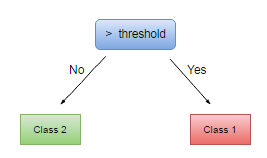

Классификатор работает следующим образом. На вход поступает одно число x, если x \* polarity >= threshold \* polarity, то классификатор возвращает 1, иначе 0. polarity равно либо 1 либо -1 и задает знак неравенства между threshold и x.

Чтобы обучить такой классификатор нам необходимо выбрать оптимальную точку разделения, минимизирующую количество мисклассификаций, взвешенных с помощью весов, полученных на очередном раунде бустинга

$$
\epsilon = \sum_i w_i |h_j(x_i) - y_i|
$$


Идея алгоритма следующая:

Пусть $w$ -- массив весов примеров, упорядоченных по значению признаков. Считаем, что все примеры имеют разное значение признака x. Если порог стоит в примере i, и polarity = 1, то функция потерь будет равна

$$
\epsilon = \sum_{j=1}^{i-1} w_j [y_j=1] + \sum_{j=i}^n w_j [y_j=0]
$$

[сумма весов всех примеров класса 1 строго слева от порога] + [сумма весов всех примеров класса 0 справа от порога(включая пример, в котором установлен порог)]

Допустим, мы знаем эти суммы (они называются кумулятивными), для всех возможных значений порога. Тогда, нужно просто сложить их и выбрать наименьшую.

Пример:

w = [2, 2, 2, 2, 2]

y = [0, 1, 0, 1, 1]

x = [1, 2, 3, 4, 5]

Если порог находится в x = 1

error = () + (2 + 2) т.к. слева от 1 нет ничего, а справа два неправильно классифицированных ноля веса 2

Сдвигаем порог вправо в x = 2

error = () + (2) т.к. слева нет единиц, а справа один ноль

Сдвигаем на x = 3

error = (2) + (2) т.к. слева одна единица, а справа один ноль

и т.д.

Можно в явном виде выписать все кумулятивные суммы

Сумма весов объектов класса один слева, если порог = x[i] 

s1 = [0, 0, 2, 2, 4]

Сумма весов объектов класса ноль справа, если порог = x[i] 

s2 = [4, 2, 2, 0, 0]

Заметим, что ошибка в позиции x[i] = s2[i] + s1[i] и оптимум лежит в позиции 2, с ошибкой = 2

Хотя второй вариант выглядит медленнее, он может быть эффективнее, если воспользоваться векторизованными примитивами numpy.  

Нужным примитивом является numpy.cumsum, реализуйте алгоритм с его помощью. Не забудьте, что нужно также посчитать оптимальный порог для polarity = -1

In [154]:
# from sklearn.tree import DecisionTreeClassifier
# from multiprocess.pool import Pool
import numba


@numba.jit()
def get_error(args):
    X, w, y, polarity = args
    if polarity == 1:
        # print(X, y)
        s1 = np.concatenate((np.array([0]), np.cumsum(w * y)[:-1]))
        s2 = np.cumsum(w[::-1] * (1 - y)[::-1])[::-1]
        # print(s1, s2)
        errors = s1 + s2
        i = np.argmin(errors)
        return errors[i], X[i], polarity
    else:
        # print(X, y)
        s1 = np.concatenate((np.array([0]), np.cumsum(w * (1 - y))[:-1]))
        s2 = np.cumsum((w * y)[::-1])[::-1]
        # print(s1, s2)
        errors = s1 + s2
        i = np.argmin(errors)
        return errors[i], X[i - 1], polarity
        # s1 = np.concatenate((np.array([0]), np.cumsum(w * first)[:-1]))
        # s2 = np.concatenate((np.cumsum(w[::-1] * second[::-1])[::-1][1:], np.array([0])))
        # print(s1, s2)
        # errors = s1 + s2
        # i = np.argmin(errors)
        # return errors[i], X[i], polarity


# pool = Pool(2)

class DecisionStump:
    def __init__(self, threshold=0, polarity=1):
        self.threshold = threshold
        self.polarity = polarity

    def train(self, X, y, w, indices):
        """
            Функция осуществляет обучение слабого классификатора

            На входе:
                X -- одномерный отсортированный numpy массив со значениями признака
                y -- одномерный numpy массив со значением класса для примера (0|1)
                Порядок y -- до сортировки X
                w -- одномерный numpy массив со значением весов признаков
                Порядок w -- до сортировки X
                indices -- одномерный numpy массив, перестановка [несортированный X] -> [сортированный X]
                Массив indices нужен для оптимизации,
                чтобы не сортировать X каждый раз, мы предсортируем значения признаков
                для всех примеров. При этом мы сохраняем отображение между сортированными
                и изначальными индексами, чтобы знать соответствие между x, y и w

                indices[i] == изначальный индекс элемента, i-го в порядке сортировки

            На выходе:

            численное значение ошибки обученного классификатора
        """

        # def get_error(X, w, y, polarity):
        #     if polarity > 0:
        #         equal_one = y == 1
        #         equal_zero = y == 0
        #     else:
        #         equal_one = y == 0
        #         equal_zero = y == 1
        #     error = np.sum(w[equal_zero])
        #     x = X[0]
        #     for i in range(1, len(w)):
        #         new_error = np.sum(w[:i][equal_one[:i]]) + np.sum(w[i:][equal_zero[i:]])
        #         # print(new_error, w[:i][equal_one[:i]], w[i:][equal_zero[i:]])
        #         if new_error < error:
        #             x = (X[i - 1] + X[i]) / 2
        #             error = new_error
        #     return error, x
        #
        # w = np.take(w, indices)
        # y = np.take(y, indices)
        #
        # error, self.threshold = get_error(X, w, y, self.polarity)
        # if error > 0:
        #     new_error, new_threshold = get_error(X, w, y, -self.polarity)
        #     if new_error < error:
        #         error = new_error
        #         self.threshold = new_threshold
        #         self.polarity = -self.polarity
        #
        # return error

        w = np.take(w, indices)
        y = np.take(y, indices)

        l = list(map(get_error, [(X, w, y, 1), (X, w, y, -1)]))
        # print(l)
        error, self.threshold, self.polarity = l[0] if l[0][0] < l[1][0] else l[1]
        return error

    def classify(self, x):
        return x * self.polarity >= self.threshold * self.polarity
        # # Классификация должна работать как на конкретном занчении x
        # # так и на множестве значений ndarray

    def __repr__(self):
        return "Threshold: {}, polarity: {}".format(self.threshold, self.polarity)

## Протестируем базовый классификатор

In [155]:
classifier1 = DecisionStump(1, 1)

assert (classifier1.classify(1) == 1)
assert (classifier1.classify(10) == 1)
assert (classifier1.classify(0) == 0)
assert ((classifier1.classify(np.array([1, 0, 10])) == np.array([1, 0, 1])).all())

In [156]:
classifier = DecisionStump()
w = [2, 2, 2, 2, 2]
y = [0, 1, 0, 1, 1]
X = [1, 2, 3, 4, 5]
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
print(classifier, error)

Threshold: 2, polarity: 1 2


In [157]:
classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([0, 0, 1, 1, 1])
w = np.asarray([1, 1, 1, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
print(classifier, error)
assert (error == 0.0)
assert (classifier.threshold > 1 and classifier.threshold <= 2 and classifier.polarity == 1)

classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([0, 0, 1, 1, 1])
w = np.asarray([1, 1, 1, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
print(classifier, error)
assert (error == 0.0)
assert (classifier.threshold > 1 and classifier.threshold <= 2 and classifier.polarity == 1)

classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([1, 1, 0, 0, 0])
w = np.asarray([1, 1, 1, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
print(classifier, error)
assert (error == 0.0)
assert (classifier.threshold >= 1 and classifier.threshold < 2 and classifier.polarity == -1)

classifier = DecisionStump()
X = np.asarray([0, 1, 2, 3, 4])
y = np.asarray([0, 1, 0, 1, 1])
w = np.asarray([1, 1, 10, 1, 1])
error = classifier.train(X, y, w, [0, 1, 2, 3, 4])
print(classifier, error)
assert (error == 1.0)
assert (classifier.threshold > 2 and classifier.threshold <= 3 and classifier.polarity == 1)

Threshold: 2, polarity: 1 0
Threshold: 2, polarity: 1 0
Threshold: 1, polarity: -1 0
Threshold: 3, polarity: 1 1


## Тренировка базового классификатора на всех признаках и выбор лучшего (2 балла)

Сейчас, когда мы умеем тренировать слабый классификатор, необходимо найти лучший слабый классификатор по всем признакам. 

In [158]:
def train_classifier(classifier_type, X, y, w, indices):
    classifier = classifier_type()
    error = classifier.train(X, y, w, indices)
    return error, classifier


def learn_best_classifier(classifier_type, X, y, w, indices):
    """
    Функция находит лучший слабый классификатор

    На входе:
        classifier_type -- класс классификатора (DecisionStump в нашем случае)
        X -- двумерный numpy массив, где X[i, j] -- значение признака i для примера j
        Каждый X[i] отсортирован по возрастанию
        y -- одномерный numpy массив с классом объекта (0|1). Порядок y соответствует порядку примеров в датасете
        w -- одномерный numpy массив весов для каждого примера. Порядок w соответствует порядку примеров в датасете
        indices -- список одномерных numpy массивов.
        indices[i, j] == изначальный индекс элемента, j-го в порядке сортировки для i-го признака

    На выходе:
        best_classifier -- лучший слабый классификатор
        best_error -- его ошибка
        best_feature_ind -- номер признака, на котором он был обучен (одна из HaarFeatures)
    """
    best_error = 1e10
    best_classifier = None
    best_feature_ind = None

    features_count = X.shape[1]
    errors = np.zeros(features_count)
    classifiers = [None] * features_count

    # натренируем каждый классификатор по каждому признаку
    for i in range(0, features_count):
        # print(X[i].shape)
        errors[i], classifiers[i] = train_classifier(classifier_type, X[i], y, w, indices[i])
        if errors[i] < best_error:
            best_error = errors[i]
            best_classifier = classifiers[i]
            best_feature_ind = i

    # выберем наилучший и сохраним лучший классификатор, ошибку, признак и индекс признака в
    # best_classifier, best_error, best_feature, best_feature_ind
    return best_classifier, best_error, best_feature_ind

## Бустинговый классификатор (2 балла)

Реализуйте классификацию для сильного классификатора. Для этого нужно посчитать взвешенную линейную комбинацию слабых классификаторов и сравнить результат с порогом.

$
h(x) = \begin{cases}   
   1 &\sum_{t=1}^T \alpha_t h_t (x) >= \frac{1}2 \sum_{t=1}^T \alpha_t \\
   0 &otherwise
\end{cases}
$

In [159]:
class BoostingClassifier:
    def __init__(self, classifiers, alphas, features, threshold=None):
        self.classifiers = classifiers
        self.alphas = alphas
        self.features = features
        # print(alphas, sum(alphas))
        self.threshold = sum(alphas) / 2 if threshold is None else threshold

    def classify(self, X):
        """
        На входе:
        X -- одномерный или двумерный numpy массив признаков

        На выходе:
        1, если ансамбль выдает значение больше threshold и 0 если меньше
        """
        res = np.zeros(X.shape[1])

        for classifier, alpha, feature in zip(self.classifiers, self.alphas, self.features):
            # print(res.shape, classifier.classify(X[feature]).shape)
            # print(weight * classifier.classify(X[feature]))
            res += classifier.classify(X[feature]) * alpha

        # здесь так же как и с пеньком нужно,
        # что бы модель могла принимать сразу несколько объектов
        # и выдвавать на них предсказания
        # pprint(res)
        # pprint(np.sum(res, axis=0))
        # pprint(res >= self.threshold)
        return res >= self.threshold

    def predict_proba(self, X):
        # # На выходе должно быть вещественное значение классификатора
        # # Этот метод пригодится для построения ROC и PR кривых и ранжирования предсказаний
        # res = np.zeros((len(X), len(self.classifiers)))
        #
        # for classifier, weight, feature in zip(self.classifiers, self.weights, self.features):
        #     res += weight * classifier.classify(X[feature])
        #
        # # здесь так же как и с пеньком нужно,
        # # что бы модель могла принимать сразу несколько объектов
        # # и выдвавать на них предсказания
        # return res
        raise NotImplementedError

## Обучение методом бустинга

Вам необходимо реализовать приведенный в статье алгоритм, пользуясь всеми блоками, которые мы уже построили.

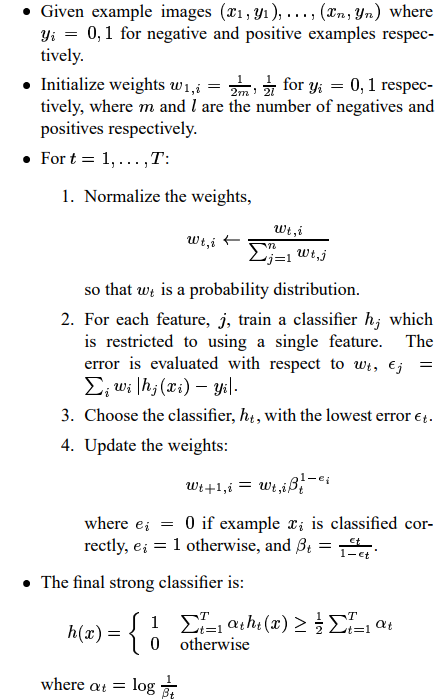

In [162]:
def learn_face_detector(X, y, turns=200, eps=1e-15, verbose_turn=20):
    """
    На входе:
        X -- двумерный numpy массив, X[i,j] == значение признака j для примера i
        y -- одномерный numpy массив с классом объекта (0|1)
        turns -- максимальное количество раундов обучения
        eps -- критерий останова (алгоритм останавливается, если новый классификатор имеет ошибку меньше eps)
        verbose_turn -- частота вывода метрик

    На выходе:
        классификатор типа BoostingClassifier
    """
    # Транспонируем матрицу пример-признак к матрице признак-примеры
    X_t = X.copy().T
    indices = np.zeros(X_t.shape).astype(int)
    # Предсортируем каждый признак, но сохраним соответствие между индексами
    # в массиве indices для каждого прзинака
    for index in tqdm(range(0, len(X_t)), desc='sorting'):
        # print(index)
        indices[index] = X_t[index].argsort()
        # print(X_t[index])
        X_t[index].sort()

    # X_t = X_t.T
    # indices = indices.T
    # найдем количество положительных примеров в выборке
    # n_positive = np.sum(y)

    # найдем количество отрицательных примеров в выборке
    # n_negative = len(y) - n_positive

    # инициализируем веса
    w = np.ones(X.shape[0])

    classifiers = []
    features_ind = []
    alpha = []

    # создадим словарь для записей значений метрик
    history = defaultdict(list)

    # print(X_t.shape, indices.shape, y.shape, w.shape)

    for turn in tqdm(range(0, turns)):

        # нормируем веса так, чтобы сумма была равна 1
        w /= np.sum(w)

        # найдём лучший слабый классификатор
        weak_classifier, error, feature_ind = learn_best_classifier(DecisionStump, X_t, y, w, indices)

        # вычислим предсказания
        weak_classifier_predictions = np.take(
            weak_classifier.classify(X_t[feature_ind]),
            np.argsort(indices[feature_ind])
        )

        # найдем beta
        beta = error / (1 - error)

        # e[i] == 0 если классификация правильная и 1 наоборот
        e = weak_classifier_predictions != y

        # каждый правильно классифицированный вес нужно домножить на beta
        w *= np.power(beta, 1 - e)

        # print(error, beta)

        # добавим к ансамблю новый классификатор с его весом и признаком
        classifiers.append(weak_classifier)
        features_ind.append(feature_ind)
        alpha.append(np.log(1 / beta))

        # print(alpha, sum(alpha))

        # посчитаем промежуточные метрики
        strong_classifier = BoostingClassifier(classifiers, alpha, features_ind)
        pos_predictions = strong_classifier.classify(positive_features.T)
        neg_predictions = strong_classifier.classify(negative_features.T)
        # print(pos_predictions, neg_predictions)
        correct_positives = sum(pos_predictions) / len(pos_predictions)
        correct_negatives = 1 - sum(neg_predictions) / len(neg_predictions)

        # запишем значения в словарь
        history["correct_positives"].append(correct_positives)
        history["correct_negatives"].append(correct_negatives)

        # каждые verbose_turn раундов выведем результаты
        if turn % verbose_turn == 0:
            print(f"Раунд {turn + 1}")
            print(f"Взвешенная ошибка текущего слабого классификатора: {error}")
            print(f"Корректно классифицированные лица {correct_positives}")
            print(f"Корректно классифицированные не-лица {correct_negatives}")

        # если ошибка уже почти нулевая, остановимся
        if 1 - correct_positives < eps and 1 - correct_negatives < eps:
            break

    return history, BoostingClassifier(classifiers, alpha, features_ind)

Тренировка сильного классификатора может занять длительное время, вплоть до нескольких часов, если вы использовали много признаков и примеров. На 1000 примеров и 10000 признаков, 200 раундов тренировки должны завершиться в течение получаса.

Чтобы понять, что тренировка идет правильно, убедитесь, что точность постоянно растет и в какой-то момент становится идеальной.

Ошибка каждого конкретного классификатора, при этом, должна возрастать от ~0.1 до ~0.3-0.4

In [163]:
# % % time
history, strong_classifier = learn_face_detector(
    X_train, y_train,
    # verbose_turn=1, turns=2
)

sorting:   0%|          | 0/21684 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Раунд 1
Взвешенная ошибка текущего слабого классификатора: 0.11511111111111066
Корректно классифицированные лица 0.902
Корректно классифицированные не-лица 0.865
Раунд 21
Взвешенная ошибка текущего слабого классификатора: 0.3491675556863436
Корректно классифицированные лица 0.981
Корректно классифицированные не-лица 0.9733333333333334
Раунд 41
Взвешенная ошибка текущего слабого классификатора: 0.3827144964430198
Корректно классифицированные лица 0.987
Корректно классифицированные не-лица 0.9853333333333333
Раунд 61
Взвешенная ошибка текущего слабого классификатора: 0.35544802021422933
Корректно классифицированные лица 0.9926666666666667
Корректно классифицированные не-лица 0.994
Раунд 81
Взвешенная ошибка текущего слабого классификатора: 0.38178227870563236
Корректно классифицированные лица 0.9943333333333333
Корректно классифицированные не-лица 0.995
Раунд 101
Взвешенная ошибка текущего слабого классификатора: 0.3867964445979654
Корректно классифицированные лица 0.995
Корректно класси

<AxesSubplot:>

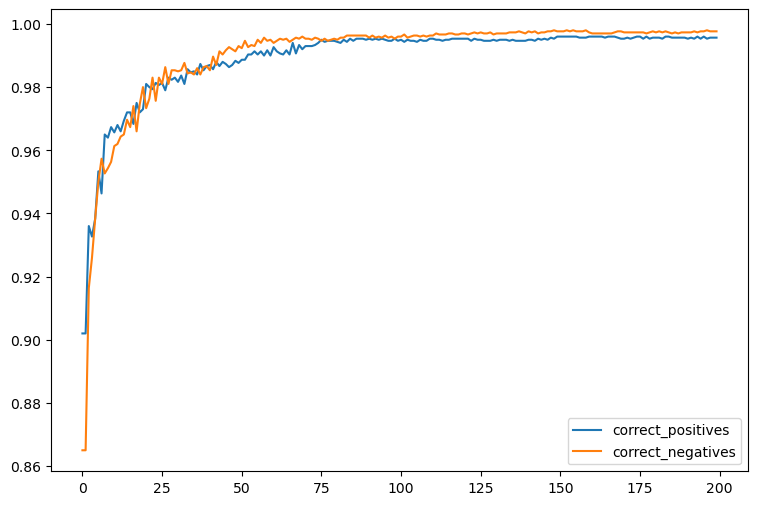

In [164]:
# Что бы убедиться что модель учится, посмотрим как меняется доля ошибок от итерации

hist_df = pd.DataFrame(history)
hist_df.plot(figsize=(9, 6))

Сохраним модель

In [167]:
with open('strong_classifier.pkl', 'wb') as f:
    pickle.dump(strong_classifier, f)

## Калибрация классификатора (2 балла)

### Посчитаем метрики качества

Неплохим будем классификатор с процентом ложных обнаружений меньше 0.1% и процентом корректных обнаружений > 90%. Это минимум, которого нужно достичь. При использовании бОльшего количества признаков, примеров и раундов тренировки, результаты могут быть лучше.

Вычислите основные метрики качества для получившейся модели, постройте PR-curve

Посмотрите, как меняются характеристики классификатора при изменении порога. Найдите такой порог, который давал бы наименьшее количество ложных обнаружений при 90% точности.

In [166]:
# Необходимо перебрать разные значения порога и посчитать соответствующие метрики (см. выше)
???

# В конце установить подходящее значение порога
strong_classifier.threshold = ???

SyntaxError: invalid syntax (1232012613.py, line 5)

# Бонусная часть (2 балла)
## Воспользуемся полученным классификатором, чтобы найти лица на изображении

Пользуясь блоками построенными в этой и предыдущей частях задания соберите детектор лиц.
Выберите и подгрузите изображение. Пройдите по нему окнами разных размеров и верните все окна, в которых классификатор нашел лицо. Не забудьте, что к каждому окну нужно применить нормализацию и сжатие до стандартного размера. Из соображений скорости, проходите по изображению с некоторым шагом. Чтобы достичь производительности, можно написать эту часть на более быстром языке.

Hint: вместо того, чтобы проходить окнами разных размеров, можно использовать одно и то же окно, вместо этого уменьшая исходное изображение. Такой вариант будет эффективнее, но нужно не забыть отсмасштабировать получившиеся окна к исходным размерам)

In [ ]:
t = np.array([[i * 3 + j for j in range(3)] for i in range(3)], dtype=float).reshape(9)

In [ ]:
t

In [ ]:
t /= np.sum(t)
t

In [ ]:
np.sum(t)

In [ ]:
np.sum(w / np.sum(w))